In [1]:
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import Backgammon as B
import agent as A
import flipped_agent as FA

In [2]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
        
    def choose_board(self, board):
        self.board = board
        self.done = False
        return np.copy(self.board)
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], self.board
        return moves, np.vstack(boards)
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player):
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        return np.copy(self.board), reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

In [3]:
def reset_graph(seed=42):
    #tf.reset_default_graph()
    #tf.set_random_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
reset_graph()

In [4]:
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H1, H2, H3, D_out = 29, 32, 64, 128, 1

actor = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H3, D_out),
    torch.nn.Softmax(dim=0),
)
critic = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H3, D_out),
    torch.nn.Tanh(),
)
memory = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H3, D_out),
    torch.nn.Tanh(),
)
# save initial parameters of transient memory
initial_memory = [copy.deepcopy(param) for param in memory.parameters()]

In [5]:
def get_action_and_value(actor, boards):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    with torch.no_grad():
        action = int(torch.multinomial(possible_actions_probs.view(1,-1), 1))
    action_value = possible_actions_probs[action]
    return action, action_value

def get_action_value(actor, boards, action):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    action_value = possible_actions_probs[action]
    return action_value

def get_action(actor, boards):
    with torch.no_grad():
        boards = torch.from_numpy(boards).float()
        possible_actions_probs = actor(boards)
        action = torch.multinomial(possible_actions_probs.view(1,-1), 1)
    return int(action)

def get_state_value(nn_model, after_state):
    after_state = torch.from_numpy(after_state).float()
    value = nn_model(after_state)
    return value

def epsilon_greedy(critic, possible_boards, epsilon=.9):
    possible_boards = torch.from_numpy(possible_boards).float()
    values = critic(possible_boards)
    if np.random.random()<epsilon:
        _ , index = values.max(0)
    else:
        index = np.random.randint(0, len(possible_boards))
    return int(index)

def composite_greedy(critic, memory, possible_boards, epsilon=1):
    possible_boards = torch.from_numpy(possible_boards).float()
    critic_values = critic(possible_boards)
    memory_values = memory(possible_boards)
    values = critic_values + memory_values
    if np.random.random()<epsilon:
        _ , index = values.max(0)
    else:
        index = np.random.randint(0, len(possible_boards))
    return int(index)

In [6]:
"""
Use: valuefn_temp = search(pre_state, memory, n_dreams, max_steps)
Input: pre_state is current state,
       memory is the transient memorythe value function,
       old_value is the value of last after state
       n_dreams is number of dreams,
       max_steps is maximum number of steps,
Output: memory has been updated for episodes in dream
"""
def search(pre_state, pre_value, pre_dice, n_dreams, max_steps = 1000):    
    # Dream n_dreams
    for dreams in range(n_dreams):
        # Clear eligibility trace
        memory_Z = [0 for layer in critic.parameters()]
        done = False
        step = 1
        state = env.choose_board(np.copy(pre_state))
        #Set after_state = pre_state to deal with possibilty of no legal move on first step
        #after_state = env.choose_board(np.copy(pre_state))
        old_value = pre_value
        
        # play one round and update
        while not (done or step > max_steps):
            if step == 1:
                dice = pre_dice
            else:
                dice = B.roll_dice()
                
            for i in range(1 + int(dice[0] == dice[1])):
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                if len(possible_moves) == 0:
                    after_state = np.copy(state)
                    #skip_round = True
                    #after_state = next_state
                    break
                # Use composite value function to choose action
                action = composite_greedy(critic, memory, possible_boards)
                after_state, reward, done = env.step(possible_moves[action], player = 1)
                if done:
                    break
            if not done:
                with torch.no_grad():
                    critic_value = get_state_value(critic, after_state)
                    
                memory_value = get_state_value(memory, after_state)
                value = critic_value + memory_value
                #calc critic gradient
                memory.zero_grad()
                memory_value.backward()
            else:
                value = 0
            with torch.no_grad():
                if step > 1:
                    delta = reward + gamma*value - old_value
                    for i, param in enumerate(memory.parameters()):
                        param += memory_alpha * delta * memory_Z[i]
                if not done:        
                    for i, param in enumerate(memory.parameters()):
                        memory_Z[i] = memory_lambda * memory_Z[i] + param.grad

                old_value = value
            

                # other players move
                if not done:
                    dice = B.roll_dice()
                    for i in range(1 + int(dice[0] == dice[1])):
                        next_state, reward, done = env.make_move(dice)
                        if done:
                            break
                    #next_value = get_state_value(critic, next_state)
                else:
                    next_value = 0
                
            step +=1
        if reward == -1:
            with torch.no_grad():
                delta = reward - old_value
                for i, param in enumerate(memory.parameters()):
                        param += memory_alpha * delta * memory_Z[i]

    state = env.choose_board(pre_state)

In [7]:
import time
rew_plt = []

def playAgainstRandom(num_games = 100, clear = True):
    global rew_plt
    rew = []
    for episode in range(num_games):
        env.reset()
        done = False

        while not done:
            dice = B.roll_dice()
            for i in range(1 + int(dice[0] == dice[1])):
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                if len(possible_moves) == 0:
                    break

                action = epsilon_greedy(critic, possible_boards) # No search on first step                    
                after_state, reward, done = env.step(possible_moves[action], player = 1)
                if done:
                    break

                if not done:
                    dice = B.roll_dice()
                    for i in range(1 + int(dice[0] == dice[1])):
                        next_state, reward, done = env.make_move(dice)
                        if done:
                            break


        rew.append(reward)

    if clear:
        clear_output(True)
    rew_plt.append(np.mean(np.equal(rew,1)))
    rew = []
    plt.plot(rew_plt)
    plt.axhline(0.5, color="gray")
    plt.show()
    print("Win rate:", rew_plt[-1])

EPISODE:  20 Steps: 57
EPISODE:  40 Steps: 98
EPISODE:  60 Steps: 75
EPISODE:  80 Steps: 81
EPISODE:  100 Steps: 57


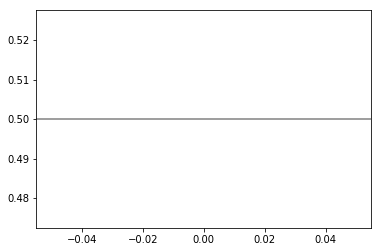

Win rate: 0.5
Time per 100: 14.320439577102661
EPISODE:  100
EPISODE:  120 Steps: 99
EPISODE:  140 Steps: 56
EPISODE:  160 Steps: 131
EPISODE:  180 Steps: 98
EPISODE:  200 Steps: 214


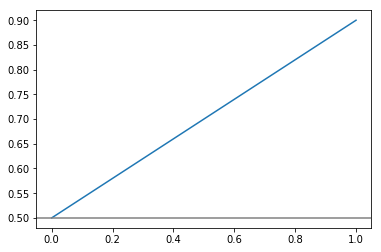

Win rate: 0.9
Time per 100: 22.3291175365448
EPISODE:  200
EPISODE:  220 Steps: 58
EPISODE:  240 Steps: 188
EPISODE:  260 Steps: 706
EPISODE:  280 Steps: 189
EPISODE:  300 Steps: 859


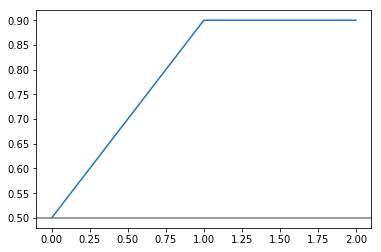

Win rate: 0.9
Time per 100: 43.482611417770386
EPISODE:  300
EPISODE:  320 Steps: 169
EPISODE:  340 Steps: 896
EPISODE:  360 Steps: 102
EPISODE:  380 Steps: 391
EPISODE:  400 Steps: 373


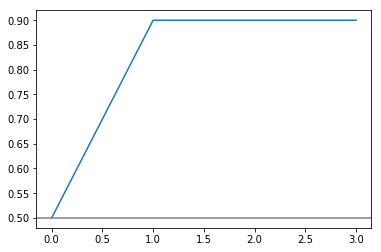

Win rate: 0.9
Time per 100: 57.26935791969299
EPISODE:  400
EPISODE:  420 Steps: 398
EPISODE:  440 Steps: 1270
EPISODE:  460 Steps: 458
EPISODE:  480 Steps: 160
EPISODE:  500 Steps: 706


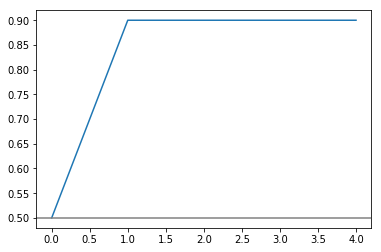

Win rate: 0.9
Time per 100: 85.41234683990479
EPISODE:  500
EPISODE:  520 Steps: 1371
EPISODE:  540 Steps: 590
EPISODE:  560 Steps: 288
EPISODE:  580 Steps: 659
EPISODE:  600 Steps: 463


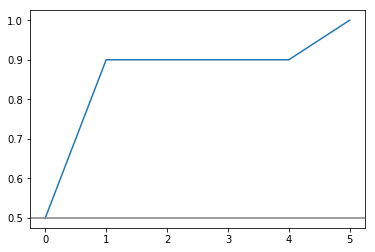

Win rate: 1.0
Time per 100: 74.70926427841187
EPISODE:  600
EPISODE:  620 Steps: 406
EPISODE:  640 Steps: 65
EPISODE:  660 Steps: 292
EPISODE:  680 Steps: 900
EPISODE:  700 Steps: 176


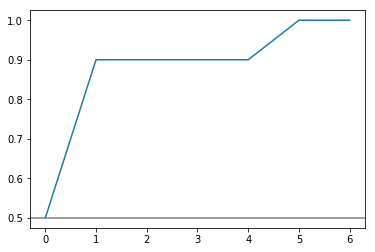

Win rate: 1.0
Time per 100: 77.84707641601562
EPISODE:  700
EPISODE:  720 Steps: 838
EPISODE:  740 Steps: 1069
EPISODE:  760 Steps: 1479
EPISODE:  780 Steps: 899
EPISODE:  800 Steps: 1221


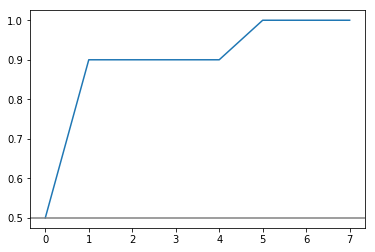

Win rate: 1.0
Time per 100: 111.92077159881592
EPISODE:  800
EPISODE:  820 Steps: 1131
EPISODE:  840 Steps: 788
EPISODE:  860 Steps: 413
EPISODE:  880 Steps: 185
EPISODE:  900 Steps: 391


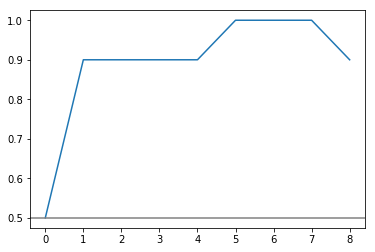

Win rate: 0.9
Time per 100: 110.81723737716675
EPISODE:  900
EPISODE:  920 Steps: 267
EPISODE:  940 Steps: 588
EPISODE:  960 Steps: 381
EPISODE:  980 Steps: 1313
EPISODE:  1000 Steps: 584


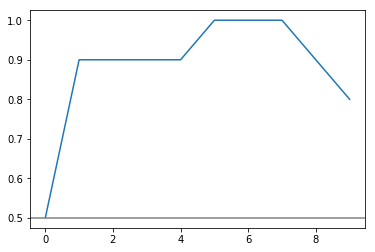

Win rate: 0.8
Time per 100: 105.29400420188904
EPISODE:  1000
EPISODE:  1020 Steps: 1540
EPISODE:  1040 Steps: 838
EPISODE:  1060 Steps: 521
EPISODE:  1080 Steps: 775
EPISODE:  1100 Steps: 684


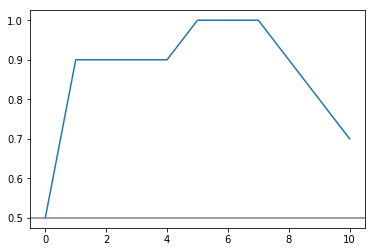

Win rate: 0.7
Time per 100: 129.96769666671753
EPISODE:  1100
EPISODE:  1120 Steps: 146
EPISODE:  1140 Steps: 235
EPISODE:  1160 Steps: 65
EPISODE:  1180 Steps: 1004
EPISODE:  1200 Steps: 1554


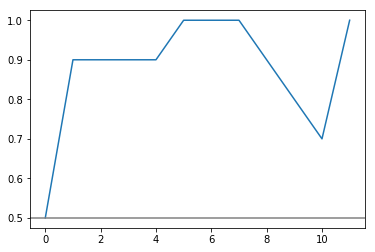

Win rate: 1.0
Time per 100: 116.91229271888733
EPISODE:  1200
EPISODE:  1220 Steps: 1134
EPISODE:  1240 Steps: 129
EPISODE:  1260 Steps: 385
EPISODE:  1280 Steps: 410
EPISODE:  1300 Steps: 515


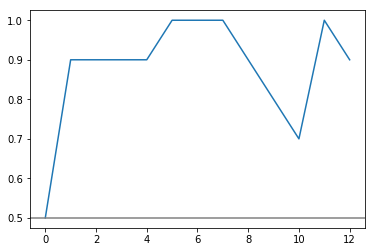

Win rate: 0.9
Time per 100: 110.42777943611145
EPISODE:  1300
EPISODE:  1320 Steps: 803
EPISODE:  1340 Steps: 284
EPISODE:  1360 Steps: 443
EPISODE:  1380 Steps: 592
EPISODE:  1400 Steps: 1809


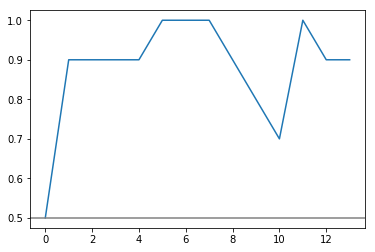

Win rate: 0.9
Time per 100: 132.47916746139526
EPISODE:  1400
EPISODE:  1420 Steps: 851
EPISODE:  1440 Steps: 270
EPISODE:  1460 Steps: 953
EPISODE:  1480 Steps: 950
EPISODE:  1500 Steps: 290


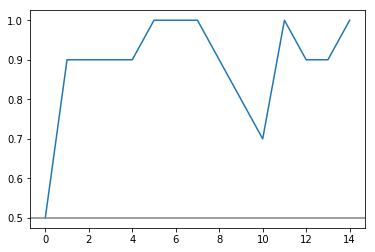

Win rate: 1.0
Time per 100: 138.42294216156006
EPISODE:  1500
EPISODE:  1520 Steps: 1340
EPISODE:  1540 Steps: 490
EPISODE:  1560 Steps: 740
EPISODE:  1580 Steps: 1977
EPISODE:  1600 Steps: 1364


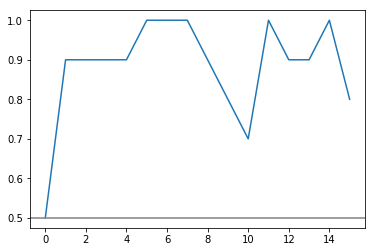

Win rate: 0.8
Time per 100: 115.98440194129944
EPISODE:  1600
EPISODE:  1620 Steps: 717
EPISODE:  1640 Steps: 566
EPISODE:  1660 Steps: 1192
EPISODE:  1680 Steps: 1564
EPISODE:  1700 Steps: 365


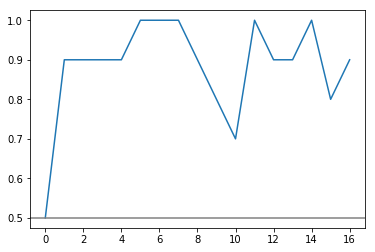

Win rate: 0.9
Time per 100: 148.66230130195618
EPISODE:  1700
EPISODE:  1720 Steps: 784
EPISODE:  1740 Steps: 1831
EPISODE:  1760 Steps: 269
EPISODE:  1780 Steps: 528
EPISODE:  1800 Steps: 1668


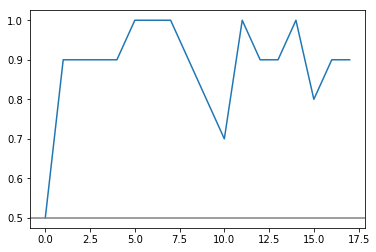

Win rate: 0.9
Time per 100: 136.25944328308105
EPISODE:  1800
EPISODE:  1820 Steps: 459
EPISODE:  1840 Steps: 651
EPISODE:  1860 Steps: 1450
EPISODE:  1880 Steps: 712
EPISODE:  1900 Steps: 606


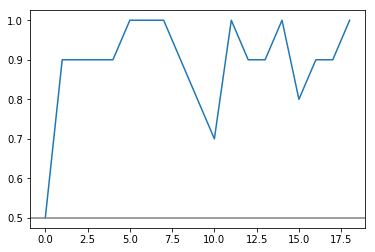

Win rate: 1.0
Time per 100: 148.7534041404724
EPISODE:  1900
EPISODE:  1920 Steps: 720
EPISODE:  1940 Steps: 152
EPISODE:  1960 Steps: 553
EPISODE:  1980 Steps: 895
EPISODE:  2000 Steps: 686


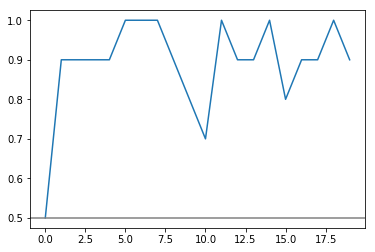

Win rate: 0.9
Time per 100: 140.63815903663635
EPISODE:  2000


In [8]:
gamma = 0.99
actor_alpha = 0.01
critic_alpha = 0.01
memory_alpha = 0.01
actor_lambda = 0.7
critic_lambda = 0.7
memory_lambda = 0.7
forever = 2000

plt_iter = 100

env = backgammon()


tic = time.time()

for episode in range(1,forever+1):
    if (episode%20==0):
        print("EPISODE: ", episode, "Steps:", step)
        
    env.reset()
    done = False
    step = 1
    value_grad = [ [0 for layer in actor.parameters()] for player in range(2) ]
    critic_Z = [ [0 for layer in critic.parameters()] for player in range(2) ]
    value = [[0,0],[0,0]] #value[player][0(old),1(new)]
    
#    # Transient memory
#    with torch.no_grad():
#        for i, param in enumerate(memory.parameters()):
#            param.data.copy_(initial_memory[i])
#    n_dreams = 5
#    max_rounds = 5
    
    
    player = 0
    
    while not done:
        dice = B.roll_dice()
        for i in range(1 + int(dice[0] == dice[1])):
            possible_moves, possible_boards = env.legal_moves(dice, 1)
            if len(possible_moves) == 0:
                break
            '''                
            if (step > 1):
                pre_state = np.copy(env.board)
                search(pre_state, old_value, n_dreams, max_rounds)
                action = composite_greedy(critic, memory, possible_boards)
            else:
                action = epsilon_greedy(critic, possible_boards) # No search on first step
            '''
            action = epsilon_greedy(critic, possible_boards) # this or ^
                
            after_state, reward, done = env.step(possible_moves[action], player = 1)
            if done:
                break
        if not done:
            value[player][0] = float(value[player][1]) # old_value
            value[player][1] = get_state_value(critic, after_state)
            critic.zero_grad()
            value[player][1].backward()
            with torch.no_grad():
                for i, param in enumerate(critic.parameters()):
                    value_grad[player][i] = param.grad
                    
            if (step>2):
                with torch.no_grad():
                    reward = 0 # Reward er 0
                    delta = reward + gamma*value[player][1] - value[player][0]

                    for i, param in enumerate(critic.parameters()):
                        param += critic_alpha * delta * critic_Z[player][i]
                        critic_Z[player][i] = critic_lambda * critic_Z[player][i] + value_grad[player][i]
            step += 1
            player = not player
            env.swap_player()
            
    value[player][0] = float(value[player][1])
    value[player][1] = 0
    
    value[not player][0] = float(value[not player][1])
    value[not player][1] = 0
    
    with torch.no_grad():
        delta1 = reward + gamma*value[player][1] - value[player][0]
        delta2 = -reward + gamma*value[not player][1] - value[not player][0]

        for i, param in enumerate(critic.parameters()):
            param += critic_alpha * delta * critic_Z[player][i]
            param += critic_alpha * delta2 * critic_Z[not player][i]
            
    if episode%plt_iter == 0:
        toc = time.time()
        playAgainstRandom(num_games = 10, clear = False)
        print("Time per {}: {}".format(plt_iter, toc-tic))
        print("EPISODE: ", episode)
        tic = time.time()
        

